This assignment will give you a real (active) research topic that I've discussed a little bit in class: predicting carbon storage as a function of high-resolution gridded data. In the class google drive you will find all the data you need. I added it just recently so if you don't have it, be sure to go get it first. 

This assignment will have you use the automated variable selection approach within LASSO to deal with a common situation in regressions on raster-stacks: we have so much data everything is significant but will lead to massive overfitting. The basic approach used here will involve reading in 2d rasters, flattening them into a 1d column ready to add to a dataframe shaped object, which we will use as our X matrix.

Please turn in the completed Notebook (.ipynb) file that includes the results you generate. 

Below is some starter code along with specific assignment questions.


In [1]:
# Load libraries
import numpy as np
import os
from osgeo import gdal
from sklearn.linear_model import Lasso
from matplotlib import pyplot as plt
from statsmodels.api import OLS
import pandas as pd


## Step 1: Download the data and set paths

Download the latest data from the class's google drive. In there, you will need the the files in `Data/python_assignment_2` data and assign a relative path to the `soyo_tile` directory in that assignment directory. It is your task to ensure your script runs in the right location and the data is stored in the right location that this relative path works.

In [2]:
# Step 1 code

data_dir = '../data/python_assignment_2/soyo_tile' 


## Step 2: Set raster paths 

Assign each of the raster paths in the directory to a dictionary for later use. I've included most of the code (so you don't have to waste your time typing), but add in the missing paths.

In [3]:
# Step 2 code

raster_paths = {}

# First is the dependent varable, Above Ground Carbon (AGB) in tons, measured at 30 meters globally (here it is clipped to a smaller area)
raster_paths['agb_observed_baccini_2000_30m'] = os.path.join(data_dir, "agb_observed_baccini_2000_30m.tif")

# Here are some of the independent variables
raster_paths['CRFVOL_M_sl1_250m'] = os.path.join(data_dir, "CRFVOL_M_sl1_250m.tif")
raster_paths['HISTPR_250m'] = os.path.join(data_dir, "HISTPR_250m.tif")
raster_paths['OCDENS_M_sl1_250m'] = os.path.join(data_dir, "OCDENS_M_sl1_250m.tif")
raster_paths['PHIHOX_M_sl1_250m'] = os.path.join(data_dir, "PHIHOX_M_sl1_250m.tif")
raster_paths['roughness_30s'] = os.path.join(data_dir, "roughness_30s.tif")
raster_paths['SLGWRB_250m'] = os.path.join(data_dir, "SLGWRB_250m.tif")
raster_paths['SLTPPT_M_sl1_250m'] = os.path.join(data_dir, "SLTPPT_M_sl1_250m.tif")
raster_paths['terrain_ruggedness_index_30s'] = os.path.join(data_dir, "terrain_ruggedness_index_30s.tif")
raster_paths['TEXMHT_M_sl1_250m'] = os.path.join(data_dir, "TEXMHT_M_sl1_250m.tif")
raster_paths['wc2.0_bio_30s_01'] = os.path.join(data_dir, "wc2.0_bio_30s_01.tif")
raster_paths['alt_30s'] = os.path.join(data_dir, "alt_30s.tif")
raster_paths['AWCh1_M_sl1_250m'] = os.path.join(data_dir, "AWCh1_M_sl1_250m.tif")
raster_paths['BDRICM_M_250m'] = os.path.join(data_dir, "BDRICM_M_250m.tif")
raster_paths['BDRLOG_M_250m'] = os.path.join(data_dir, "BDRLOG_M_250m.tif")
raster_paths['BLDFIE_M_sl1_250m'] = os.path.join(data_dir, "BLDFIE_M_sl1_250m.tif")

## Step 3: Open the rasters

Our dependent variable will be 30 meter observations of carbon storage from Baccini et al. (unpublished, but soon to be published) data. The label I assigned in the dictionary above was agb_observed_baccini_2000_30m for this variable. Use gdal.Open, GetRasterBand(1) and ReadAsArray() to read this geotiff as a numpy file

Side note: If you get an error like: "ERROR 4: This is a BigTIFF file.  BigTIFF is not supported by this version of GDAL and libtiff." make sure you have installed gdal with the mamba method from lecture 1. 

In [4]:
# Step 3 code

# Specify the path to the geotiff file
agb_observed_path = raster_paths['agb_observed_baccini_2000_30m']

# Open the geotiff file
agb_observed_dataset = gdal.Open(agb_observed_path)

agb_observed_band = agb_observed_dataset.GetRasterBand(1)

# Read the band as a numpy array
agb_observed_array = agb_observed_band.ReadAsArray()

# Now agb_observed_array contains the pixel values as a numpy array
print("Shape of AGB Observed Array:", agb_observed_array.shape)
print("AGB Observed Array:", agb_observed_array)

Shape of AGB Observed Array: (2000, 2000)
AGB Observed Array: [[123 122  75 ... 130 128 125]
 [125 124 124 ... 121 130 124]
 [125 128 126 ... 124 124 126]
 ...
 [  0   0   0 ... 155 136 143]
 [  0   0   0 ... 135 132 198]
 [  0   0   0 ... 135 123 119]]


## Step 4: Define some arrays

Create an empty numpy array (or full of zeros) of the right shape to house all our raster data. A very CPU-efficient way of arranging a stack of 2d rasters (which would be 3d once stacked up), is to flatten each 2d raster into a longer 1d array. This will go into our X matrix. In order to create the right sized X matrix, first get the n_obs and n_vars by inspecting the dependent variable raster and the dictionary of inputs above. Note that the n_vars should be the number of independent AND dependent variables.

In [5]:
# Step 4 code

# Assuming the shape of the dependent variable raster is the same for all rasters
dependent_variable_raster = raster_paths['agb_observed_baccini_2000_30m']
dependent_variable_dataset = gdal.Open(dependent_variable_raster)
n_obs = dependent_variable_dataset.RasterYSize * dependent_variable_dataset.RasterXSize

# Number of variables is the total number of rasters
n_vars = len(raster_paths)

# Close the dataset
dependent_variable_dataset = None

# Create an empty numpy array of zeros for your X matrix
X_matrix = np.zeros((n_obs, n_vars))

# Now X_matrix is an empty array ready to store your flattened raster data
print("Shape of X matrix:", X_matrix.shape)


Shape of X matrix: (4000000, 16)


## Step 5: Load all the independent variables

- Iterate through the dictionary and load each raster as a 2d array
- flatten it to 1d using the .flatten() method in numpy
- Assign this 1d array to the correct column of the data array. By convention, the depvar will be the first column.

Hint, assuming you have arranged your X array in the correct way, it should have observations (pixels) as rows and variables as cols. Given that each flattened array is for one variable and is as long as there are rows, a convenient way of assigning it would be to use numpy slice notation, potentially similar to:

`data_array[:, column_index_integer]`

The first colon just denotes the whole row and the column index is an integer you could create pointing to the right row.

Some incomplete code to get you started is below.

In [6]:
# Step 5 code

col_index = 0

feature_names = []

for name, path in raster_paths.items():
    print('Loading', path)

    # Open the raster dataset
    raster_dataset = gdal.Open(path)
    
    # Get the raster band
    band = raster_dataset.GetRasterBand(1)
    
    flattened_raster_array = band.ReadAsArray().flatten()
    
    X_matrix[:, col_index] = flattened_raster_array

    col_index = col_index + 1
    
    feature_names.append(name)


Loading ../data/python_assignment_2/soyo_tile\agb_observed_baccini_2000_30m.tif
Loading ../data/python_assignment_2/soyo_tile\CRFVOL_M_sl1_250m.tif
Loading ../data/python_assignment_2/soyo_tile\HISTPR_250m.tif
Loading ../data/python_assignment_2/soyo_tile\OCDENS_M_sl1_250m.tif
Loading ../data/python_assignment_2/soyo_tile\PHIHOX_M_sl1_250m.tif
Loading ../data/python_assignment_2/soyo_tile\roughness_30s.tif
Loading ../data/python_assignment_2/soyo_tile\SLGWRB_250m.tif
Loading ../data/python_assignment_2/soyo_tile\SLTPPT_M_sl1_250m.tif
Loading ../data/python_assignment_2/soyo_tile\terrain_ruggedness_index_30s.tif
Loading ../data/python_assignment_2/soyo_tile\TEXMHT_M_sl1_250m.tif
Loading ../data/python_assignment_2/soyo_tile\wc2.0_bio_30s_01.tif
Loading ../data/python_assignment_2/soyo_tile\alt_30s.tif
Loading ../data/python_assignment_2/soyo_tile\AWCh1_M_sl1_250m.tif
Loading ../data/python_assignment_2/soyo_tile\BDRICM_M_250m.tif
Loading ../data/python_assignment_2/soyo_tile\BDRLOG_M_25

# Step 6: 

Extract the first array row of the data_array and assign it to y. Assign the rest to X.

In [7]:
# Step 6 code
data_array = X_matrix

y = data_array[: ,0]

X = data_array[: ,1:]


# Step 7:

Split the X and y into testing and training data such that the training data is the first million pixels and the testing data is the next 200,000. Do this using numpy slice notation on the X and y variables you created.

In [8]:
# Step 7 code
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Step 8 (optional but useful):

To make the code run faster, we are going to use every 10th pixel. We can easily get this via numpy slicing again, using x_train[::10] to get every 10th pixel.

In [9]:
# Step 8 code
X_train_unfold = X_train
y_train_unfold = y_train
X_train = X_train_unfold[::10]
y_train = y_train_unfold[::10]


# Step 9:

Create a Lasso object (using the default penalty term alpha) and fit it to the training data. Create and print out a vector of predicted carbon values. Also print out the score using the lasso object's .score() method on the TESTING data. Print out the fitted lasso score.

In [10]:
# Step 9 code
from sklearn.linear_model import LassoCV, Lasso
model_lasso = Lasso(random_state=0, max_iter=10000)
y_train_lasso = model_lasso.fit(X_train, y_train)
y_train_hat_lasso = model_lasso.predict(X_train)
print('y_hat_lasso', y_train_hat_lasso)
lasso_score = model_lasso.score(X_test, y_test)
print("R^2 Score on Testing Data:", lasso_score)


y_hat_lasso [106.51432167   0.72692479  16.45675404 ...  34.96738521 127.85210336
   0.72692479]
R^2 Score on Testing Data: 0.6205601175848547


# Step 10, optional and just for fun:.

To view how our projections LOOK, we can create a predicted matrix on the whole X, reshape it back into the original 2d shape and look at it. You can compare this to the input array to visualize how it looks. Note that this will only work if you name your objects like mine.

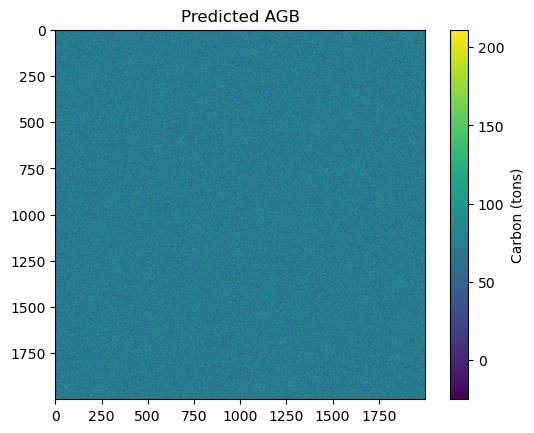

In [24]:
# Step 10 code

# Reshape the predicted values back to the original 2D shape
y_hat = model_lasso.predict(np.concatenate((X_train_unfold, X_test), axis=0))

y_hat_reshaped = y_hat.reshape(agb_observed_array.shape)

# Visualize the predicted matrix
plt.imshow(y_hat_reshaped, cmap='viridis', vmin=y_hat_reshaped.min(), vmax=y_hat_reshaped.max())
plt.title('Predicted AGB')
plt.colorbar(label='Carbon (tons)')
plt.show()



The result is strange, and I further examine the data and try to use y (the original value instead of predicted one to plot). It works this time.

In [ ]:
y_reshaped = y.reshape(agb_observed_array.shape)

# Visualize the predicted matrix
plt.imshow(y_reshaped)
plt.title('Predicted AGB')
plt.colorbar(label='Carbon (tons)')
plt.show()

And I wonder whether the predicted y-hat is not accurate, so I calculate the summary statistics of both y and y-hat. But they are similar. Maybe some information was lost during reshaping or predicting y-hat.

In [22]:
y_hat_series = pd.Series(y_hat)
y_hat_summary = y_hat_series.describe()
print(y_hat_summary)

y_series = pd.Series(y)
y_summary = y_series.describe()
print(y_summary)

count    4.000000e+06
mean     7.281240e+01
std      5.113035e+01
min     -2.496590e+01
25%      1.955982e+01
50%      7.674030e+01
75%      1.182558e+02
max      2.111996e+02
dtype: float64
count    4.000000e+06
mean     7.281657e+01
std      6.575607e+01
min      0.000000e+00
25%      2.000000e+00
50%      5.400000e+01
75%      1.230000e+02
max      2.820000e+02
dtype: float64


Then I plot profiles along an Axis. The figure here may provide some additional information.

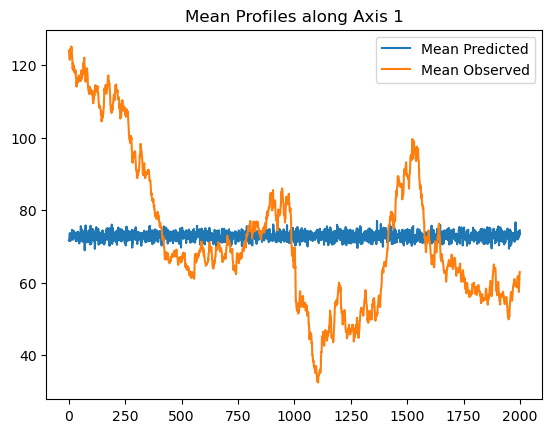

In [30]:
import numpy as np

# Choose a specific axis (0 for rows, 1 for columns)
axis = 1

# Compute the mean profile along the chosen axis
mean_predicted_profile = np.mean(y_hat_reshaped, axis=axis)
mean_observed_profile = np.mean(agb_observed_array, axis=axis)

# Plot the mean profiles
plt.plot(mean_predicted_profile, label='Mean Predicted')
plt.plot(mean_observed_profile, label='Mean Observed')
plt.title(f'Mean Profiles along Axis {axis}')
plt.legend()
plt.show()


# Step 11:

Create a list of 30 alphas using ` np.logspace(-1, 3, 30)`. 

Using a for loop iterate over those alphas and run the Lasso model like above, but using the alpha values in the loop. Print out the fit score at each step. Using matplotlib, plot how this value changes as alpha changes. Finally, extract the best alpha of the bunch. 

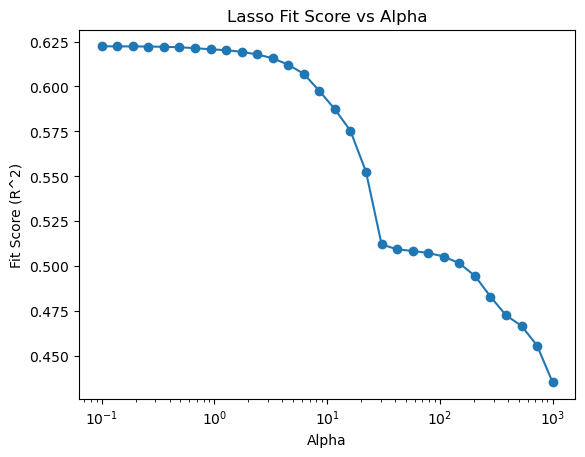

Best Alpha: 0.1


In [12]:
# Step 11 code
# Create a list of 30 alphas using np.logspace(-1, 3, 30)
alphas = np.logspace(-1, 3, 30)

# Lists to store fit scores and coefficients for each alpha
fit_scores = []
coefficients = []

# Iterate over alphas
for alpha in alphas:
    # Create and train the Lasso model
    lasso = Lasso(alpha=alpha,random_state=0, max_iter=10000)
    lasso.fit(X_train, y_train)
    
    # Append the fit score for this alpha
    fit_scores.append(lasso.score(X_test, y_test))
    
    # Append the coefficients for this alpha
    coefficients.append(lasso.coef_)

# Plot how the fit score changes as alpha changes
plt.plot(alphas, fit_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Fit Score (R^2)')
plt.title('Lasso Fit Score vs Alpha')
plt.show()

# Find the best alpha
best_alpha = alphas[np.argmax(fit_scores)]
print(f"Best Alpha: {best_alpha}")

# Step 12: 

Rerun the lasso with that best value and identify all of the coefficiencts that were "selected" ie had non-zero values. Save these coefficient indices and labels to a list.

In [13]:
# Step 12 code

# Create and train the Lasso model with the best alpha
lasso_best = Lasso(alpha=best_alpha,random_state=0, max_iter=10000)
lasso_best.fit(X_train, y_train)

# Get the indices of selected coefficients (non-zero coefficients)
selected_coeff_indices = np.where(lasso_best.coef_ != 0)[0]

# Get the corresponding feature names for selected coefficients
selected_coeff_labels = np.array(feature_names)[selected_coeff_indices]

# Print the selected coefficients
print("Selected Coefficient Indices:", selected_coeff_indices)
print("Selected Coefficient Labels:", selected_coeff_labels)



Selected Coefficient Indices: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14]
Selected Coefficient Labels: ['agb_observed_baccini_2000_30m' 'CRFVOL_M_sl1_250m' 'HISTPR_250m'
 'OCDENS_M_sl1_250m' 'PHIHOX_M_sl1_250m' 'SLGWRB_250m' 'SLTPPT_M_sl1_250m'
 'terrain_ruggedness_index_30s' 'TEXMHT_M_sl1_250m' 'wc2.0_bio_30s_01'
 'alt_30s' 'AWCh1_M_sl1_250m' 'BDRICM_M_250m' 'BDRLOG_M_250m']


# Step 13:

Using Statsmodels, run an OLS version on the selected variables.

Use print to show the results table.

Write a description of any advantages this approach has over vanilla OLS.


In [14]:
# Step 13 code

import statsmodels.api as sm

# Assuming X_selected is the subset of features with non-zero coefficients
X_selected = X[:, selected_coeff_indices]

# Add a constant term to the X matrix
X_selected = sm.add_constant(X_selected)

# Create an OLS model
ols_model = sm.OLS(y, X_selected)

# Fit the OLS model
ols_results = ols_model.fit()

# Print the results table
print(ols_results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                 4.617e+05
Date:                Mon, 27 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:41:56   Log-Likelihood:            -2.0496e+07
No. Observations:             4000000   AIC:                         4.099e+07
Df Residuals:                 3999985   BIC:                         4.099e+07
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6243      0.050     12.504      0.0

Lasso performs automatic feature selection by setting some coefficients to exactly zero. This can be beneficial when dealing with high-dimensional datasets with many irrelevant or redundant features. And Lasso introduces regularization, which helps prevent overfitting by penalizing large coefficients. This can improve the model's generalization performance on new, unseen data.

Furthermore, Lasso can handle multicollinearity among features, as it tends to select one variable from a group of highly correlated variables and it can improve the stability of the model estimates, especially when the number of predictors is larger than the number of observations.